In [2]:
## Importing Libraries

import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, PredefinedSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import itertools
import torch
import random
import time
import copy
import matplotlib.pyplot as plt

SEED = 42
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower
fix_random(SEED)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print('Using device:', device)

Using device: mps


In [2]:
## Load Data

FILENAME = "train_dataset.csv"

df1 = pd.read_csv(FILENAME, encoding='ISO-8859-1', sep=",", low_memory=False)
df1 = df1.dropna()
y = df1["type"]
X = df1.drop(columns=["type", "label"])

err_arr = X.loc[X["src_bytes"] == "0.0.0.0"]
X = X.drop(index=err_arr.index)
y = y.drop(index=err_arr.index)
X.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

# X = X.to_numpy()
y = y.to_numpy()

In [3]:
## Categorical Embedding

X_cat = X.select_dtypes(include=['object'])
X_num = X.select_dtypes(exclude=['object'])
oe = preprocessing.OrdinalEncoder()
oe.fit(X_cat)
X_cat = oe.transform(X_cat)
X = np.concatenate((X_cat, X_num), axis=1)
print(X.shape)

le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)

(616983, 44)


In [4]:
## Train, Validation and Test Set

indeces = np.arange(X.shape[0])
train_idx, test_idx = train_test_split(indeces, test_size=0.1, stratify=y, random_state=SEED)
test_idx, val_idx = train_test_split(test_idx, test_size=0.5, stratify=y[test_idx], random_state=SEED)

fold = np.zeros(X.shape[0])
fold[train_idx] = -1

ps = PredefinedSplit(fold)
ps.get_n_splits()

y_test = y[test_idx]
y_train = y[train_idx]
y_val = y[val_idx]

X_test = X[test_idx,:]
X_train = X[train_idx,:]
X_val = X[val_idx,:]

In [19]:
## Class Weights

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(4.069505313301575), 1: np.float64(0.338101268905721), 2: np.float64(1.1325392616765246), 3: np.float64(4.5436870959823255), 4: np.float64(98.62948490230906), 5: np.float64(2.9863611917822954), 6: np.float64(1.1967069675222517), 7: np.float64(63.82574712643678), 8: np.float64(0.2880357707889181), 9: np.float64(0.9751918652640452)}


In [6]:
## FFNN

def train_model(model, criterion, optimizer, epochs, data_loader, val_loader, device, scheduler, patience):
    n_iter = 0

    best_model = None
    best_val_loss = float('inf')
    epochs_since_last_improvement = 0

    start = time.time()

    loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        model.train()
        start_epoch = time.time()
        
        loss_train = 0
        for data in zip(data_loader):
            x, y = data[0]
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y.long())
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            n_iter += 1
        scheduler.step()
        loss_train /= len(data_loader)
        loss_history.append(loss_train)

        val_loss, _, _ = test_model(model, criterion, val_loader)
        val_loss_history.append(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            epochs_since_last_improvement = 0
        elif epochs_since_last_improvement >= patience:
            break
        else:
            epochs_since_last_improvement += 1

        print('Epoch [{}/{}] - {:.2f} seconds - train_loss: {:.6f} - val_loss: {:.6f} - patience: {}'.format(epoch+1,
              epochs, time.time() - start_epoch, loss_train, val_loss, epochs_since_last_improvement), end='\r')

    print('\nTraining ended after {:.2f} seconds - Best val_loss: {:.6f}'.format(time.time() - start, best_val_loss))

    return best_model, loss_history, val_loss_history
    
def test_model(model, criterion, loader):
    model.eval()
    y_pred = np.array([])
    y_true = np.array([])

    total_loss = 0

    with torch.no_grad():
        # model takes in input from both data loaders
        for data in loader:
            x, y = data
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y.long())
            total_loss += loss.item()
            y_pred = np.append(y_pred, torch.argmax(y_hat, 1).cpu().numpy())
            y_true = np.append(y_true, y.cpu().numpy())


    avg_loss = total_loss / len(loader)
    
    return avg_loss, y_pred, y_true

class FFNN(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_size, dropout_prob=0, depth=1):
        super(FFNN, self).__init__()

        self.input = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.LeakyReLU(),
            torch.nn.BatchNorm1d(hidden_size),
            torch.nn.Dropout(dropout_prob),
        )

        self.branch1 = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.LeakyReLU(),
            torch.nn.BatchNorm1d(hidden_size),
            torch.nn.Dropout(dropout_prob),
        )

        for _ in range(depth):
            self.branch1.extend([
                torch.nn.Linear(hidden_size, hidden_size),
                torch.nn.LeakyReLU(),
                torch.nn.BatchNorm1d(hidden_size),
                torch.nn.Dropout(dropout_prob),
            ])

        self.branch2 = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, hidden_size//2),
            torch.nn.LeakyReLU(),
            torch.nn.BatchNorm1d(hidden_size//2),
            torch.nn.Dropout(dropout_prob),
        )

        for _ in range(depth):
            self.branch2.extend([
                torch.nn.Linear(hidden_size//2, hidden_size//2),
                torch.nn.LeakyReLU(),
                torch.nn.BatchNorm1d(hidden_size//2),
                torch.nn.Dropout(dropout_prob),
            ])
        
        self.output = torch.nn.Sequential(
            torch.nn.Linear(hidden_size//2, output_size),
        )
        
    def forward(self, x):
        x = self.input(x)
        x = self.branch1(x)
        x = self.branch2(x)
        o  = self.output(x)
        return o

In [7]:
## Preprocess and splitting

# Apply LDA
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
X_train = lda.transform(X_train)
X_val = lda.transform(X_val)
X_test = lda.transform(X_test)


num_feature = X_train.shape[1]
num_classes = len(np.unique(y_train))

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor), batch_size=y_val.shape[0], shuffle=False)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=y_test.shape[0], shuffle=False)

In [8]:
input_size = X_train.shape[1]
out_size = len(np.unique(y_train))
batch_sizes = [8]
hidden_sizes =  [64]
learning_rate = [0.001]
step_size_lr_decay = [10]
nums_epochs = [1000]
depths = [1]
dropout_prob = [0.2]
patience = 20
weight_decay = [0.01]

hyperparameters = itertools.product(batch_sizes, hidden_sizes, depths, nums_epochs, learning_rate, step_size_lr_decay, dropout_prob, weight_decay)
n_comb = len(hidden_sizes)*len(depths)*len(nums_epochs)*len(learning_rate)*len(step_size_lr_decay)*len(dropout_prob)*len(batch_sizes)*len(weight_decay)
print (f'Number of hyperparameter combinations: {n_comb}')

current_iter = 0
best_model = None
best_loss = float('inf')
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights.values()), dtype=torch.float32).to(device))
history_loss = []
history_val_loss = []
best_global_params = ''
for batch, hidden_size, depth, num_epoch, lr, step_size, drop_prob, w_d in hyperparameters:
    current_iter += 1

    print("\nIterations {}/{} - Training with hidden_size={}, depth_head={}, num_epochs={}, batch={}, lr={}, step_size={}, drop_prob={}, weight_decay={}".format(
        current_iter, n_comb, hidden_size, depth, num_epoch, batch, lr, step_size, drop_prob,w_d))
    
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)), batch_size=batch, shuffle=True)

    model = FFNN(input_size=input_size, output_size=out_size, hidden_size=hidden_size, dropout_prob=drop_prob, depth=depth).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)   

    model, hl, hvl = train_model(model, criterion, optimizer, num_epoch, train_loader, val_loader, device, scheduler, patience)
    
    loss, _, _, = test_model(model, criterion, val_loader)


    if loss < best_loss:
        best_loss = loss
        best_model = copy.deepcopy(model)
        best_params = f'hidden_size: {hidden_size}, depth: {depth}, num_epochs: {num_epoch}, batch: {batch}, lr: {lr}, step_size: {step_size}, drop_prob: {drop_prob}, weight_decay: {w_d}'

        history_loss = hl
        history_val_loss = hvl

        torch.save(best_model.state_dict(), 'classification_best_model.pth')
    print("Model Loss: {:.6f} - Best Loss: {:.6f}".format(loss, best_loss))   



Number of hyperparameter combinations: 1

Iterations 1/1 - Training with hidden_size=64, depth_head=1, num_epochs=1000, batch=8, lr=0.001, step_size=10, drop_prob=0.2, weight_decay=0.01
Epoch [31/1000] - 457.66 seconds - train_loss: 0.168460 - val_loss: 0.306723 - patience: 20
Training ended after 14663.97 seconds - Best val_loss: 0.196127
Model Loss: 0.196127 - Best Loss: 0.196127


Best model hyperparameters: hidden_size: 64, depth: 1, num_epochs: 1000, batch: 8, lr: 0.001, step_size: 10, drop_prob: 0.2, weight_decay: 0.01
Best model accuracy: 0.9834030276508152
Best model F1: 0.9837520972700143
Test Loss: 0.2047485113143921
Test Accuracy: 0.9834030276508152


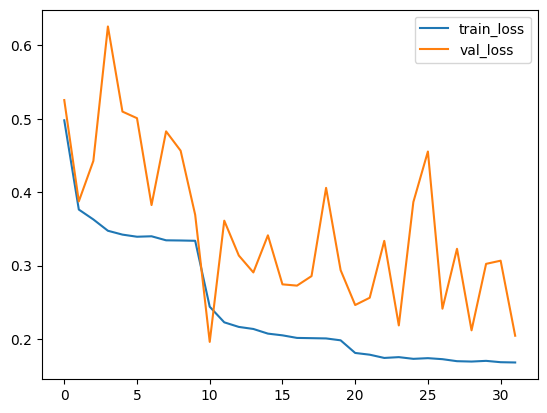

In [9]:
# Evaluate the best model
best_model.eval()
test_loss, y_pred, y_true = test_model(best_model, criterion, test_loader)

y_true = le.inverse_transform(y_true.astype(int))
y_pred = le.inverse_transform(y_pred.astype(int))

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Best model hyperparameters: {best_params}")
print(f"Best model accuracy: {acc}")
print(f"Best model F1: {f1}")

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {accuracy_score(y_true, y_pred)}')
plt.plot(hl, label='train_loss')
plt.plot(hvl, label='val_loss')
plt.legend()
plt.show()

---

# TABNET

In [3]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer

class TabNet(torch.nn.Module):
    '''
    Wrapper class for TabNetClassifier
    '''
    def __init__(self, n_d,
                 n_a,
                 n_steps,
                 gamma,
                 optimizer_fn,
                 n_independent,
                 n_shared,
                 epsilon,
                 seed,
                 lambda_sparse,
                 clip_value,
                 momentum,
                 optimizer_params,
                 scheduler_params,
                 mask_type,
                 scheduler_fn,
                 device_name,
                 output_dim,
                 batch_size,
                 num_epochs,
                 unsupervised_model,
                 verbose=0):
        super(TabNet, self).__init__()

        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.unsupervised_model = unsupervised_model
        self.network = TabNetClassifier(n_d=n_d,
                                        n_a=n_a,
                                        n_steps=n_steps,
                                        gamma=gamma,
                                        optimizer_fn=optimizer_fn,
                                        n_independent=n_independent,
                                        n_shared=n_shared,
                                        epsilon=epsilon,
                                        seed=seed,
                                        lambda_sparse=lambda_sparse,
                                        clip_value=clip_value,
                                        momentum=momentum,
                                        optimizer_params=optimizer_params,
                                        scheduler_params=scheduler_params,
                                        mask_type=mask_type,
                                        scheduler_fn=scheduler_fn,
                                        device_name=device_name,
                                        output_dim=output_dim,
                                        verbose=verbose)
    
    def fit_model(self, X_train, y_train, X_val, y_val, criterion):
        self.network.fit(X_train=X_train, 
                         y_train=y_train, 
                         eval_set=[(X_train,y_train),(X_val, y_val)], 
                         eval_metric=['accuracy'], 
                         patience=10, 
                         batch_size=self.batch_size, 
                         virtual_batch_size=128, 
                         num_workers=0, 
                         drop_last=True, 
                         max_epochs=self.num_epochs, 
                         loss_fn=criterion, 
                         from_unsupervised=self.unsupervised_model)

    def predict(self, X):
        return self.network.predict(X)
    
    def explain(self, X):
        return self.network.explain(X)
    
    def feature_importances(self):
        return self.network.feature_importances_

def get_unsupervised_model(n_d_a,n_step,n_independent,n_shared,gamma,lr):
    tabnet_params = dict(n_d=n_d_a, 
                        n_a=n_d_a,
                        n_steps=n_step,
                        gamma=gamma,
                        n_independent=n_independent,
                        n_shared=n_shared,
                        lambda_sparse=1e-3,
                        optimizer_fn=torch.optim.AdamW, 
                        optimizer_params=dict(lr=lr),
                        mask_type="sparsemax",
                        verbose=0
                        )
    unsupervised_model = TabNetPretrainer(**tabnet_params)
    return unsupervised_model

In [4]:
## Load Data

FILENAME = "train_dataset.csv"

df1 = pd.read_csv(FILENAME, encoding='ISO-8859-1', sep=",", low_memory=False)
df1 = df1.dropna()
y = df1["type"]
X = df1.drop(columns=["type", "label"])

err_arr = X.loc[X["src_bytes"] == "0.0.0.0"]
X = X.drop(index=err_arr.index)
y = y.drop(index=err_arr.index)
X.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

# X = X.to_numpy()
y = y.to_numpy()


## Categorical Embedding

X_cat = X.select_dtypes(include=['object'])
X_num = X.select_dtypes(exclude=['object'])
oe = preprocessing.OrdinalEncoder()
oe.fit(X_cat)
X_cat = oe.transform(X_cat)
X = np.concatenate((X_cat, X_num), axis=1)
print(X.shape)

le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)


## Train, Validation and Test Set

indeces = np.arange(X.shape[0])
train_idx, test_idx = train_test_split(indeces, test_size=0.1, stratify=y, random_state=SEED)
test_idx, val_idx = train_test_split(test_idx, test_size=0.5, stratify=y[test_idx], random_state=SEED)

fold = np.zeros(X.shape[0])
fold[train_idx] = -1

ps = PredefinedSplit(fold)
ps.get_n_splits()

y_test = y[test_idx]
y_train = y[train_idx]
y_val = y[val_idx]

X_test = X[test_idx,:]
X_train = X[train_idx,:]
X_val = X[val_idx,:]

## Preprocess and splitting

# Apply LDA
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# lda = LinearDiscriminantAnalysis()
# lda.fit(X_train, y_train)
# X_train = lda.transform(X_train)
# X_val = lda.transform(X_val)
# X_test = lda.transform(X_test)


num_feature = X_train.shape[1]
num_classes = len(np.unique(y_train))

# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
# y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor), batch_size=y_val.shape[0], shuffle=False)
# test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=y_test.shape[0], shuffle=False)

(616983, 44)


In [5]:
nums_epochs = [1000]
batch_sizes = [32]
patience = [20]
n_d_a = [64] # 8, 16, 32, 64
n_shared = [1] # 1, 2, 3, 4, 5
n_indipendents = [1] # 1, 2, 3, 4, 5
n_steps = [8] # 3, 4, 5, 6, 7, 8, 9, 10
gamma = [1.1] # 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0
epsilon = [1e-15]
learning_rate = [0.02]
pretraining_ratio = [0.5]
momentum = [0.99]
hyperparameters = list(itertools.product(nums_epochs, batch_sizes, patience, n_d_a, n_indipendents, n_shared, n_steps, gamma, epsilon, learning_rate, pretraining_ratio, momentum))
n_comb = len(hyperparameters)
print (f'Number of hyperparameter combinations: {n_comb}')

Number of hyperparameter combinations: 1


In [8]:
device = torch.device('cpu')
print(device)
current_iter = 0
best_acc = 0
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights.values()), dtype=torch.float32).to(device))
for num_epochs, batch_size, patience_, n_d, n_i, n_s, n_steps_, gamma_, epsilon_, lr, pretraining_ratio_, moment in hyperparameters:
    
    print(f'Iteration {current_iter+1}/{n_comb}')
    print(f'Hyperparameters: num_epochs={num_epochs}, batch_size={batch_size}, patience={patience_}, n_d={n_d}, n_indipendent={n_i}, n_shared={n_s}, n_steps={n_steps_}, gamma={gamma_}, epsilon={epsilon_}, lr={lr}, pretraining_ratio={pretraining_ratio_}, momentum={moment}')

    unsupervised_model = get_unsupervised_model(n_d, n_steps_, n_i, n_s, gamma_, lr)
        
    unsupervised_model.fit(
        X_train=X_train,
        eval_set=[X_val],
        max_epochs=num_epochs,
        patience=patience_,
        batch_size=batch_size,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
        pretraining_ratio=pretraining_ratio_,
    )

    model = TabNet(n_d=n_d,
                   n_a=n_d,
                   n_steps=n_steps_,
                   gamma=gamma_,
                   optimizer_fn=torch.optim.AdamW,
                   n_independent=n_i,
                   n_shared=n_s,
                   epsilon=epsilon_,
                   seed=SEED,
                   lambda_sparse=1e-4,
                   clip_value=1,
                   momentum=moment,
                   optimizer_params=dict(lr=lr),
                   scheduler_params=dict(step_size=10, gamma=0.9),
                   mask_type='sparsemax',
                   scheduler_fn=torch.optim.lr_scheduler.StepLR,
                   device_name=device,
                   output_dim=len(np.unique(y_train)),
                   batch_size=batch_size,
                   num_epochs=num_epochs,
                   unsupervised_model=None,
                   verbose=0)
    model.fit_model(X_train, y_train, X_val, y_val, criterion)    
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    if acc > best_acc:
        best_acc = acc
        best_model = copy.deepcopy(model)
        best_hyperparameters = f"num_epochs={num_epochs}, batch_size={batch_size}, patience={patience_}, n_d={n_d}, n_indipendent={n_i}, n_shared={n_s}, n_steps={n_steps_}, gamma={gamma_}, epsilon={epsilon_}, lr={lr}, pretraining_ratio={pretraining_ratio_}, momentum={moment}"
    current_iter += 1

cpu
Iteration 1/1
Hyperparameters: num_epochs=1000, batch_size=32, patience=20, n_d=64, n_indipendent=1, n_shared=1, n_steps=8, gamma=1.1, epsilon=1e-15, lr=0.02, pretraining_ratio=0.5, momentum=0.99

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_unsup_loss_numpy = 1.0478564659499673e+22


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_1_accuracy = 0.95961


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [9]:
print(f'Best model hyperparameters: {best_hyperparameters}')
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc}\n')

Best model hyperparameters: num_epochs=1000, batch_size=32, patience=20, n_d=64, n_indipendent=1, n_shared=1, n_steps=8, gamma=1.1, epsilon=1e-15, lr=0.02, pretraining_ratio=0.5, momentum=0.99
Accuracy: 0.9578592498946481



In [59]:
from sklearn.metrics import classification_report, f1_score, accuracy_score

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_test), y=y_test)

print(classification_report(y_test, y_pred))
print(f'F1 Score: {f1_score(y_test, y_pred, average="weighted")}')
print(f'Balanced accuracy: {accuracy_score(y_test, y_pred, sample_weight=(np.array([class_weights[i] for i in y_test])))}')

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       758
           1       0.99      0.99      0.99      9124
           2       0.96      1.00      0.98      2724
           3       0.89      0.96      0.92       679
           4       0.20      0.81      0.31        31
           5       0.79      0.57      0.66      1033
           6       0.95      0.89      0.92      2578
           7       0.01      0.04      0.02        48
           8       0.99      0.99      0.99     10710
           9       0.93      0.90      0.92      3164

    accuracy                           0.96     30849
   macro avg       0.75      0.82      0.76     30849
weighted avg       0.96      0.96      0.96     30849

F1 Score: 0.9594971415455029
Balanced accuracy: 0.8154334380667612


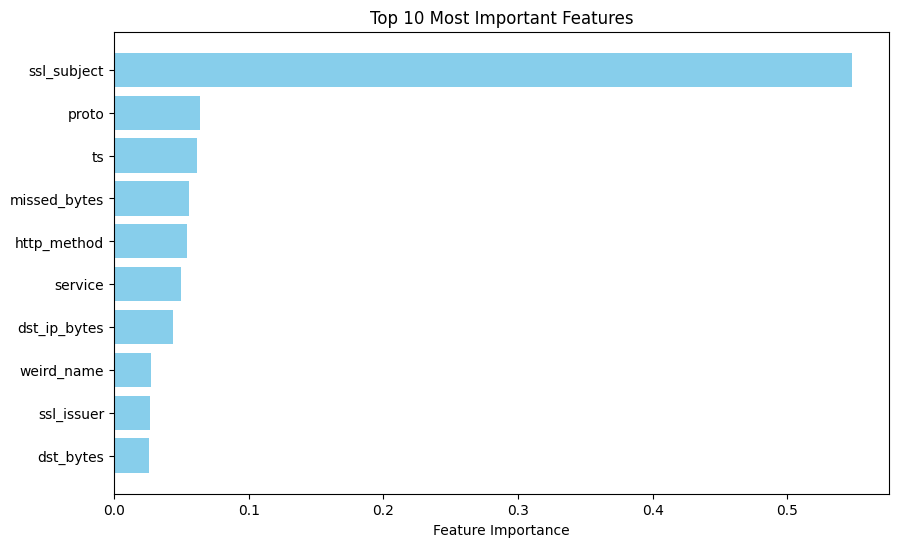

In [10]:
# Assuming `feature_importances` is a numpy array containing the importance values
# and `feature_names` is a list of names corresponding to the features
feature_importances = best_model.network.feature_importances_
feature_names = df1.drop(columns=["label"]).columns

# Sort the feature importances in descending order and select the top 10
indices = np.argsort(feature_importances)[-10:][::-1]
top_features = feature_importances[indices]
top_feature_names = feature_names[indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_feature_names, top_features, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Top 10 Most Important Features")
plt.gca().invert_yaxis()  # To show the most important feature at the top
plt.show()

---